In [2]:
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt, matplotlib
import shutil
import networkx as nx
from matplotlib.patches import Patch
from glob import glob
from Bio import SeqIO
from Bio.SeqUtils import GC
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

## Overview

The SAGs typically have lower completeness than the MAGs but also lower contamination values. Here we investigate if SAG completeness can be increased by merging SAGs with 95% ANI.

We do this using **checkm merge** on each cluster with two or more SAGs.

## Functions

In [3]:
def calc_gc_hist(f, window=1000, bins=50):
    gc_values = [GC(rec.seq[i:i+window]) for rec in SeqIO.parse(f, "fasta") for i in range(len(rec.seq)-window)]
    y, x = np.histogram(gc_values, bins=bins)
    return x, y

In [4]:
def find_fasta(g):
    src1="../../data/genomes/{g}/{g}.fna".format(g=g)
    src2="../../data/genomes/{g}/{g}.a.fna".format(g=g)
    if os.path.exists(src1):
        src = src1
    elif os.path.exists(src2):
        src = src2
    return src

In [5]:
def make_seaborn_colors(df, column, palette):
    names = df[column].unique()
    pal = sns.color_palette(palette, n_colors=len(names))
    lut = dict(zip(names,pal))
    colors = pd.Series(df[column], index=df.index).map(lut)
    return colors

In [6]:
def read_merge_stats(f, max_cont=5):
    """
    This function reads checkm merge statistics and filters it by max contamination allowed (5% by default).
    
    It then builds a graph of the remaining edges and returns all cliques that it can find.
    """
    merge_stats = pd.read_table(f, dtype={"Bin Id 1": str, "Bin Id 2": str})
    merge_stats = merge_stats.loc[merge_stats["Merged contamination"]<=max_cont]
    linkage = {}
    for i in merge_stats.index:
        bin_1,bin_2 = merge_stats.loc[i,["Bin Id 1","Bin Id 2"]]
        comp = merge_stats.loc[i,"Merged completeness"]
        if not bin_1 in linkage.keys():
            linkage[bin_1] = {}
        if not bin_2 in linkage.keys():
            linkage[bin_2] = {}
        linkage[bin_1][bin_2] = ""
        linkage[bin_2][bin_1] = ""
    g = nx.from_dict_of_dicts(linkage)
    return list(nx.find_cliques(g)), merge_stats

In [7]:
def compute_cliques(cliq, cliques, merge_stats):
    """
    This function adds the maximum possible completeness that a genome can obtain from each clique to which it belongs
    
    :param cliq A dictionary with unique clique_ids as keys, the values are dictionary with genome ids as keys
    and the maximum completeness that the genome can get from being part of the clique.
    :param cliques The cliques being investigated
    :merge_stats: A dataframe from checkm of merge statistics
    :return: Updated cliq dictionary 
    """
    for l in cliques:
        clique_id = "|".join(list(set(l)))
        cliq[clique_id] = {}
        max_comp = merge_stats.loc[(merge_stats["Bin Id 1"].isin(l))&((merge_stats["Bin Id 2"].isin(l)))].max()["Merged completeness"]
        for item in l:
            cliq[clique_id][item] = max_comp
    return cliq

In [8]:
def filter_mergers(df):
    # Check that there are no genomes that are grouped with SAGs that actually have better Max_comp
    drop = []
    for genome in df.index:
        max_comp, sagID = df.loc[genome,["Max_comp","s_sagID"]]
        for g in sagID.split("|"):
            g_max = df.loc[g,"Max_comp"]
            if g_max > max_comp:
                drop.append(genome)
                break
    return df.drop(drop)

In [9]:
def store_fasta_lengths(f):
    d = {}
    for rec in SeqIO.parse(f, "fasta"):
        d[rec.id] = len(rec.seq)
    return d
def read_gff(g):
    gff = pd.read_table("../../results/annotation/{g}/prokka/{g}.gff".format(g=g), comment="#", header=None, names=["contig","start","stop","protid"], usecols=[0,3,4,8])
    gff.loc[:,"contig"] = ["_".join(x.split("_")[1:]) for x in gff.loc[:,"contig"]]
    return gff

def get_aligned_coords(contig_id, align_range, d):
    if contig_id in d.keys():
        d[contig_id] = d[contig_id].union(set(align_range))
    else:
        d[contig_id] = set(align_range)
    return d

def get_range(start, end):
    if start > end:
        end, start = start+1, end
    else:
        end+=1
    return list(range(start, end))

def calculate_aligned(coord):
    aligned = {}
    non_aligned = {}
    for i in coord.index:
        r = coord.loc[i]
        # Calculate how much of the smaller contig is aligned
        longer, shorter = r["ref_id"], r["q_id"]
        longer_key, shorter_key = "ref", "q"
        if r["ref_full_length"] < r["q_full_length"]:
            longer, shorter = shorter, longer
            longer_key, shorter_key = shorter_key, longer_key
        s_range = get_range(r["{}_start".format(shorter_key)], r["{}_end".format(shorter_key)])
        aligned = get_aligned_coords(r["{}_id".format(shorter_key)], s_range, aligned)
    for key, value in aligned.items():
        length = coord.loc[coord.ref_id==key,"ref_full_length"]
        if len(length) == 0:
            length = coord.loc[coord.q_id==key,"q_full_length"]
        full_range = set(range(1,length.values[0]))
        non_aligned[key] = full_range.difference(aligned[key])
    return aligned, non_aligned

def get_non_aligned_ranges(non_aligned):
    ranges = {}
    for key, value in non_aligned.items():
        r = []
        value = sorted(list(value))
        if len(value) == 0:
            r.append((0,-1))
            ranges[key] = r
            continue
        start = value[0]
        for i, pos in enumerate(value[1:], start=1):
            prev = value[i-1]
            if pos != prev+1:
                end = prev
                #if abs(start-end)>=300:
                r.append((start,end))
                start = pos
        #if abs(start-pos+1)>=300:
        r.append((start,pos+1))
        ranges[key] = r
    return ranges

def read_coord_file(f):
    lines = []
    header = ["ref_start", "ref_end", "q_start", "q_end", "ref_len", "q_len", "pid", "ref_id", "q_id"]
    with open(f, 'r') as fhin:
        for i, line in enumerate(fhin):
            if i <5:
                continue
            ref_start, ref_end, _, q_start, q_end, _, ref_len, q_len, _, pid, _, ref_id, q_id = line.rstrip().rsplit()
            lines.append([int(ref_start), int(ref_end), int(q_start), int(q_end), int(ref_len), int(q_len), float(pid), ref_id, q_id])
    coord = pd.DataFrame(lines, columns=header)
    coord = pd.merge(coord, ref_lengths, left_on="ref_id", right_index=True, how="left")
    coord = pd.merge(coord, q_lengths, left_on="q_id", right_index=True, how="left")
    return coord

def calc_range_lengths(ranges, seq_len):
    range_lengths = []
    for r in ranges:
        start = list(r)[0]
        stop = list(r)[1]
        if start==0 and stop==-1:
            range_lengths.append(seq_len)
        else:
            range_lengths.append(stop+1-start)
    return range_lengths

def read_seqs(f, ranges, unique_suffix = ""):
    seqs = {}
    removed = 0
    trimmed = 0
    total = 0 # Total length
    for rec in SeqIO.parse(f, "fasta"):
        seq_len = len(rec.seq)
        total+=seq_len
        if rec.id in seqs.keys():
            seqid = "{}{}".format(rec.id,unique_suffix)
        else:
            seqid = rec.id
        # If sequence id is found in ranges, check if there are regions to remove
        if rec.id in ranges.keys():
            seq_non_aligned = 0
            range_lengths = calc_range_lengths(ranges[rec.id], seq_len)
            aligned_length = seq_len - sum(range_lengths)
            # If there is exactly one range >= 300 bp then clip the contig to the non-aligned region
            if len([l for l in range_lengths if l>=300])==1:
                suffix = 1
                for r in ranges[rec.id]:
                    start, stop = r
                    if start == 0 and stop == -1:
                        seq = rec.seq
                    else:
                        seq = str(rec.seq)[start-1:stop]
                    if len(seq)<300:
                        continue
                    # If non_aligned sequence is large enough
                    seqs["{}.{}".format(seqid,suffix)] = str(seq)
                    trimmed+=(seq_len-len(seq))
            # If the aligned length is 25% of the sequence, remove it completely
            elif aligned_length / float(seq_len) >= 0.25:
                removed+=seq_len
                continue
            else:
                seqs[seqid] = str(rec.seq)
        else:
            seqs[seqid] = str(rec.seq)
    return seqs, total, removed, trimmed

def trim_and_join_seqs(pair, ranges):
    f1,f2 = pair.split(",")
    seqs_r, total_r, removed_r, trimmed_r = read_seqs(f1, ranges)
    seqs_q, total_q, removed_q, trimmed_q = read_seqs(f2,ranges,unique_suffix="q")
    return seqs_r, seqs_q

def write_seqs(seqs, outfile):
    if not os.path.exists(os.path.dirname(outfile)):
        os.makedirs(os.path.dirname(outfile), exist_ok=True)
    with open(outfile, 'w') as fhout:
        for seqid, seq in seqs.items():
            fhout.write(">{seqid}\n{seq}\n".format(seqid=seqid, seq=seq))

## Analysis

Read the genome cluster table.

In [22]:
#clust = pd.read_table("../../results/fastANI/preprocessed.MAGs2k.SAGs.filtered.tab/genome_clusters.tsv", header=None, index_col=1, names=["Cluster","Genome"])
clust = pd.read_csv("../../results/fastANI/preprocessed.SAGs.re-assembly.pilot.tab/genome_clusters.tsv", header=None, index_col=1, sep="\t", names=["Cluster","Genome"])
sag_clust = clust.loc[~clust.index.str.contains(".2k")]
# Get clusters with at least 2 SAGs
counts = sag_clust.reset_index().groupby("Cluster").count()
multi_clusters = list(counts.loc[counts.Genome>=2].index)


In [23]:
stats = pd.read_csv("../../results/preprocess/lineage-specific/preprocessed.SAGs.re-assembly.pilot.tab", header=0, index_col=0, sep="\t")
sag_stats = stats.loc[sag_clust.index]

In [24]:
sag_df = pd.merge(sag_clust, sag_stats, left_index=True, right_index=True)
sag_df.head()

Cluster                                         name  \
Genome                                                               
3300021817  CLUSTER_1  uncultured_microorganism_SbSrfc.KA33.01.G21   
2756170308  CLUSTER_1               OP3_bacterium_JGI_KA33_H05_033   
3300022093  CLUSTER_1   uncultured_microorganism_SbSrfc.SA12.01.G7   
2756170296  CLUSTER_1               OP3_bacterium_JGI_SA12_F09_069   
2754412915  CLUSTER_1               OP3_bacterium_JGI_KA33_C08_060   

                   Marker lineage  # genomes  # markers  # marker sets  \
Genome                                                                   
3300021817  k__Bacteria (UID2565)       2921        152             93   
2756170308   k__Bacteria (UID203)       5449        104             58   
3300022093  k__Bacteria (UID2565)       2921        152             93   
2756170296   k__Bacteria (UID203)       5449        102             56   
2754412915  k__Bacteria (UID2565)       2921        152             93   

            Completeness  Contamination  Strain heterogeneity  \
Genome                                                          
3300021817         38.67           0.60                   0.0   
2756170308         34.48           0.00                   0.0   
3300022093         42.47           0.00                   0.0   
2756170296         22.32           0.00                   0.0   
2754412915         31.21           0.54                   0.0   

            Genome size (bp)  ...  Gene count  Coding density.1  \
Genome                        ...                                 
3300021817           1281262  ...        1353               NaN   
2756170308            762790  ...         698               NaN   
3300022093           1196602  ...        1156               NaN   
2756170296            999953  ...        1008               NaN   
2754412915            797374  ...         775               NaN   

            Translation table.1  # descendant genomes  Lineage: GC mean  \
Genome                                                                    
3300021817                  NaN                  88.0         44.228229   
2756170308                  NaN                  88.0         44.228229   
3300022093                  NaN                  88.0         44.228229   
2756170296                  NaN                   3.0         40.770762   
2754412915                  NaN                  88.0         44.228229   

            Lineage: GC std  Lineage: genome size (Mbp) mean  \
Genome                                                         
3300021817         7.813766                         2.421882   
2756170308         7.813766                         2.421882   
3300022093         7.813766                         2.421882   
2756170296         3.960674                         1.469131   
2754412915         7.813766                         2.421882   

            Lineage: genome size (Mbp) std  Lineage: gene count mean  \
Genome                                                                 
3300021817                        2.192133               2142.113636   
2756170308                        2.192133               2142.113636   
3300022093                        2.192133               2142.113636   
2756170296                        0.062913               1548.000000   
2754412915                        2.192133               2142.113636   

            Lineage: gene count std  
Genome                               
3300021817              1851.650802  
2756170308              1851.650802  
3300022093              1851.650802  
2756170296                63.942683  
2754412915              1851.650802  

[5 rows x 47 columns]

Check which Checkm marker file to use for analysing each cluster.

In [25]:
# Find checkm marker file to use for each cluster
clust_lin = {}
for cluster in multi_clusters:
    lineages = set([x.split(" ")[0].split("_")[-1] for x in sag_df.loc[sag_df.Cluster==cluster,"Marker lineage"]])
    if len(lineages)==1:
        clust_lin[cluster] = list(lineages)[0]
    elif "Bacteria" in lineages and "Archaea" in lineages:
        clust_lin[cluster] = "Prokaryote"
    elif "Bacteria" in lineages and not "Archaea" in lineages:
        clust_lin[cluster] = "Bacteria"
    elif "Archaea" in lineages and not "Bacteria" in lineages:
        clust_lin[cluster] = "Archaea"
    else:
        clust_lin[cluster] = "Prokaryote"
set(clust_lin.values())

{'Archaea', 'Bacteria', 'Deltaproteobacteria', 'Euryarchaeota'}

Set up the analysis directories. **This requires that the corresponding checkm marker files are available under resources/checkm/**.

In [26]:
# Set up checkm merge directories
for clust in multi_clusters:
    os.makedirs("../../results/checkm-mergers2/{}".format(clust), exist_ok=True)
    genomes = list(sag_df.loc[sag_df.Cluster==clust].index)
    marker = clust_lin[clust]
    marker_file = "../../resources/checkm/{}.ms".format(marker)
    for g in genomes:
        src1="../../data/genomes/{g}/{g}.fna".format(g=g)
        src2="../../data/genomes/{g}/{g}.a.fna".format(g=g)
        if os.path.exists(src1):
            src = src1
        elif os.path.exists(src2):
            src = src2
        shutil.copy(src,
                    dst="../../results/checkm-mergers2/{c}/{g}.fna".format(c=clust,g=g))
    shutil.copy(src=marker_file, dst="../../results/checkm-mergers2/{c}/{c}.ms".format(c=clust))

Run checkm merge

In [28]:
%%bash -s "{" ".join(multi_clusters)}"
cd /Users/john/git/scilifelab-lts/m_dopson_1701/
source activate envs/checkm
for c in $1;
do
    outfile="results/checkm-mergers2/$c/merger.tsv"
    if [ ! -f "$outfile" ]; then
        echo "Analysing merger for $c"
        checkm merge --delta_comp 0 --delta_cont 100 --merged_comp 0 --merged_cont 100 -t 4 results/checkm-mergers2/$c/$c.ms results/checkm-mergers2/$c results/checkm-mergers2/$c
    fi
done

Analysing merger for CLUSTER_1
Analysing merger for CLUSTER_10
Analysing merger for CLUSTER_11
Analysing merger for CLUSTER_12
Analysing merger for CLUSTER_13
Analysing merger for CLUSTER_14
Analysing merger for CLUSTER_15
Analysing merger for CLUSTER_16
Analysing merger for CLUSTER_17
Analysing merger for CLUSTER_18
Analysing merger for CLUSTER_19
Analysing merger for CLUSTER_2
Analysing merger for CLUSTER_20
Analysing merger for CLUSTER_21
Analysing merger for CLUSTER_22
Analysing merger for CLUSTER_23
Analysing merger for CLUSTER_24
Analysing merger for CLUSTER_25
Analysing merger for CLUSTER_26
Analysing merger for CLUSTER_27
Analysing merger for CLUSTER_28
Analysing merger for CLUSTER_29
Analysing merger for CLUSTER_3
Analysing merger for CLUSTER_30
Analysing merger for CLUSTER_31
Analysing merger for CLUSTER_32
Analysing merger for CLUSTER_33
Analysing merger for CLUSTER_34
Analysing merger for CLUSTER_35
Analysing merger for CLUSTER_36
Analysing merger for CLUSTER_37
Analysing m


*******************************************************************************
 [CheckM - merge] Identifying bins with complementary sets of marker genes.
*******************************************************************************

  Identifying marker genes in 13 bins with 4 threads:
    Finished processing 13 of 13 (100.00%) bins.

  Comparing marker sets between all pairs of bins.
  Parsing HMM hits to marker genes:
    Finished parsing hits for 13 of 13 (100.00%) bins.

  Merger information written to: results/checkm-mergers2/CLUSTER_1/merger.tsv

  { Current stage: 0:01:13.079 || Total: 0:01:13.079 }

*******************************************************************************
 [CheckM - merge] Identifying bins with complementary sets of marker genes.
*******************************************************************************

  Identifying marker genes in 4 bins with 4 threads:
    Finished processing 4 of 4 (100.00%) bins.

  Comparing marker sets between all pairs 

Compute maximum merged completeness for each genome.

In [29]:
cliq = {}
for clust in multi_clusters:
    cliques, merge_stats = read_merge_stats("../../results/checkm-mergers2/{}/merger.tsv".format(clust))
    if len(cliques)>0:
        cliq = compute_cliques(cliq, cliques, merge_stats)
cliq_df = pd.DataFrame(cliq)
cliq_df.fillna(0, inplace=True)

/Users/john/git/scilifelab-lts/m_dopson_1701/envs/jupyter_dopson/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys


Create SAG merger dataframe

In [30]:
s_sags = {}
for genome in cliq_df.index:
    cur_comp = sag_df.loc[genome, "Completeness"]
    cluster = sag_df.loc[genome,"Cluster"]
    cliq_id = cliq_df.loc[genome].sort_values(ascending=False).head(1).index[0]
    max_comp = cliq_df.loc[genome].sort_values(ascending=False).values[0]
    s_sags[genome] = {"Cluster": cluster, "s_sagID": cliq_id, "Max_comp": max_comp, "Current_comp": cur_comp}
s_sags = pd.DataFrame(s_sags).T.sort_values("Cluster")

Filter mergers so that they are unique

In [31]:
s_sags = filter_mergers(s_sags)

Plot the estimated gain in completeness from merging SAGs.

In [34]:
s_sags.head()

Cluster Current_comp Max_comp                s_sagID
2756170308  CLUSTER_1        34.48    55.77  2756170308|2756170432
2756170432  CLUSTER_1        25.32    55.77  2756170308|2756170432
2756170296  CLUSTER_1        22.32    67.31  2756170347|2756170296
2756170347  CLUSTER_1        49.53    67.31  2756170347|2756170296
2757320336  CLUSTER_4        11.29     62.5  2757320336|3300021835

In [36]:
def annotate_bars(ax, df, ylabel, colors, column="Max_comp", line_offset=0.1, text_x=1, text_y=1):
    labels = [x.get_text() for x in ax.get_xticklabels()]
    ticks = ax.get_xticks()
    offset = 1/len(labels)
    line_offset = line_offset
    s = 0
    for j, label in enumerate(labels):
        col = colors[label]
        step = j*offset
        start = s+step
        end = start+offset
        val = df.loc[label,column]
        ax.axhline(y=val, xmin=start+line_offset, xmax=end-line_offset, c=col)
        if j%2 == 0:
            ax.text(y=val+text_y,x=j-text_x, s="{}%".format(round(val,1)), fontdict={'color':col})
    ax.set_ylabel(ylabel)
    # Update ticklabels
    labels = ["{} ({})".format(g,df.loc[g,"Cluster"].split("_")[-1]) for g in labels] 
    ax.set_xticklabels(labels, rotation=90);

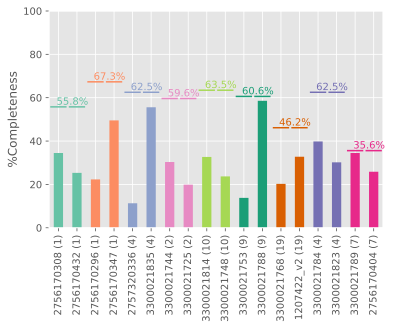

In [45]:
s_sags.sort_values("s_sagID", inplace=True)
colors1 = make_seaborn_colors(s_sags.head(10), column="s_sagID", palette="Set2").to_dict()
colors = make_seaborn_colors(s_sags.tail(8), column="s_sagID", palette="Dark2").to_dict()
colors.update(colors1)
ax1 = s_sags.Current_comp.plot(kind="bar", color=[colors[x] for x in s_sags.index])
ax1.set_ylim(0,100)
annotate_bars(ax1, s_sags, ylabel="%Completeness", colors=colors, line_offset=0.05, text_x=0.1)
plt.savefig("../../results/figures/SAGs_estimated_gain2.png", dpi=300, bbox_inches="tight")

In [46]:
s_sags = s_sags.assign(Gain=pd.Series((s_sags.Max_comp - s_sags.Current_comp) / s_sags.Current_comp * 100, index=s_sags.index))



In [47]:
s_sags.sort_values("Current_comp", ascending=False).groupby("s_sagID").first().sort_values("Gain")

Cluster  Current_comp  Max_comp       Gain
s_sagID                                                             
3300021789|2756170404   CLUSTER_7         34.48     35.58   3.190255
3300021753|3300021788   CLUSTER_9         58.55     60.58   3.467122
2757320336|3300021835   CLUSTER_4         55.58     62.50  12.450522
2756170347|2756170296   CLUSTER_1         49.53     67.31  35.897436
3300021768|1207422_v2  CLUSTER_19         32.76     46.15  40.873016
3300021784|3300021823   CLUSTER_4         39.81     62.50  56.995730
2756170308|2756170432   CLUSTER_1         34.48     55.77  61.745940
3300021748|3300021814  CLUSTER_10         32.68     63.46  94.186047
3300021744|3300021725   CLUSTER_2         30.33     59.62  96.571052

Check that the SAGs to be merged have similar GC profiles

Here we calculate %GC using a sliding window of 1kb

In [48]:
sagid_gc = {}
for i, sagid in enumerate(sorted(s_sags.s_sagID.unique()), start=1):
    print("Working on sagid {}/{}".format(i,len(s_sags.s_sagID.unique())))
    g1,g2 = sagid.split("|")
    x1,y1 = calc_gc_hist(find_fasta(g1), window=1000, bins=100)
    x2,y2 = calc_gc_hist(find_fasta(g2), window=1000, bins=100)
    sagid_gc[sagid] = {g1: {'x': x1[1:], 'y': y1}, g2: {'x': x2[1:], 'y': y2}}

Working on sagid 1/9
Working on sagid 2/9
Working on sagid 3/9
Working on sagid 4/9
Working on sagid 5/9
Working on sagid 6/9
Working on sagid 7/9
Working on sagid 8/9
Working on sagid 9/9


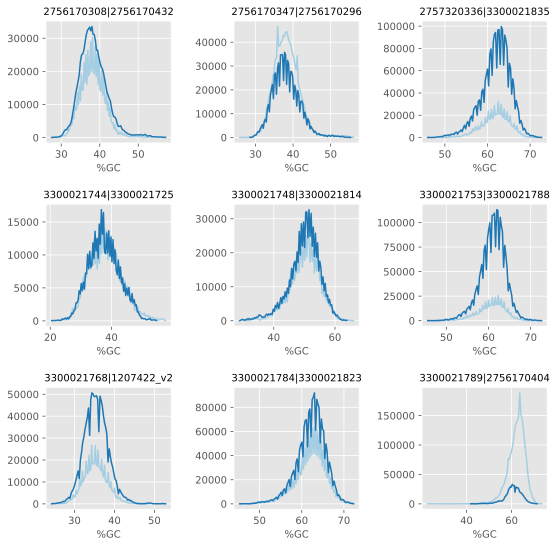

In [50]:
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=False, sharey=False, figsize=(9,9))
all_axes = list(axes[0])+list(axes[1])+list(axes[2])
for i, sagid in enumerate(sagid_gc.keys()):
    g1, g2 = sagid.split("|")
    colors = sns.color_palette("Paired", n_colors=2)
    sns.lineplot(data=pd.DataFrame(sagid_gc[sagid][g1]), x="x", y="y", color=colors[0], ax=all_axes[i])
    sns.lineplot(data=pd.DataFrame(sagid_gc[sagid][g2]), x="x", y="y", color=colors[1], ax=all_axes[i])
    all_axes[i].set_ylabel("")
    all_axes[i].set_xlabel("%GC", fontdict={'fontsize': 10})
    all_axes[i].set_title(sagid, fontdict={'fontsize': 10})
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig("../../results/figures/SAGs_mergers2_GC.png", dpi=300, bbox_inches="tight")

In [51]:
sagid_dict = dict(zip(s_sags.s_sagID.unique(), ["s-sag{i}".format(i=i) for i, sagid in enumerate(s_sags.s_sagID.unique(), start=1)]))
s_sags.loc[:,"s_sagID"] = [sagid_dict[sagid] for sagid in s_sags.s_sagID]

In [52]:
s_sags.to_csv("../../results/checkm-mergers2/s-sags.tsv", sep="\t")

In [53]:
s_sags = pd.read_csv("../../results/checkm-mergers2/s-sags.tsv", header=0, sep="\t", index_col=0)
s_sags.rename(index=lambda x: str(x), inplace=True)

## Finding redundant contigs in SAG pairs

Order each pair with more complete genome first

In [54]:
sagid_pairs = []
for sagid in sagid_dict.keys():
    g1,g2 = sagid.split("|")
    g1c = sag_df.loc[g1,"Completeness"]
    g2c = sag_df.loc[g2,"Completeness"]
    if g2c>=g1c:
        g1,g2 = g2,g1
    sagid_pairs.append("{},{}".format(find_fasta(g1),find_fasta(g2)))

Write the bash script to run nucmer on all pairs

In [55]:
script = """#!/bin/bash
source activate ~/git/scilifelab-lts/m_dopson_1701/envs/checkm
for files in {genome_pairs};
do
    f1=$(echo -e "$files"| cut -f1 -d ',')
    f2=$(echo -e "$files"| cut -f2 -d ',')
    g1=$(basename $f1 | cut -f1 -d '.')
    g2=$(basename $f2 | cut -f1 -d '.')
    outdir="../../results/checkm-mergers2/${{g1}}_${{g2}}"
    echo -e "Running nucmer on $g1 and $g2"
    mkdir -p $outdir
    nucmer -p $outdir/nucmer --coords $f1 $f2
done
""".format(
    genome_pairs=" ".join(sagid_pairs))
with open("nucmer.sh", 'w') as fh:
    fh.write(script)

In [56]:
%%bash
bash nucmer.sh

Running nucmer on 2756170308 and 2756170432
Running nucmer on 2756170347 and 2756170296
Running nucmer on 3300021835 and 2757320336
Running nucmer on 3300021744 and 3300021725
Running nucmer on 3300021814 and 3300021748
Running nucmer on 3300021788 and 3300021753
Running nucmer on 1207422_v2 and 3300021768
Running nucmer on 3300021784 and 3300021823
Running nucmer on 3300021789 and 2756170404


1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "../../results/checkm-mergers2/2756170308_2756170432/nucmer.ntref" of length 762828
# construct suffix tree for sequence of length 762828
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# process 7628 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /Users/john/git/scilifelab-lts/m_dopson_1701/envs/checkm/opt/mummer-3.23/mummer ../../results/checkm-mergers2/2756170308_2756170432/nucmer.ntref 0.16
# reading input file "/Users/john/git/scilifelab-lts/m_dopson_1701/source/notebooks/../../data/genomes/2756170432/2756170432.fna" of length 902844
# matching query-file "/Users/john/git/scilifelab-lts/m_dopson_1701/source/notebooks/../../data/genomes/2756170432/2756170432.fna"
# against subject-file "../../results/checkm-mergers2/2756170308_2756170432/nucmer.ntref"
# COMPLETETIME /Users/john/

In [59]:
merged_stats = {}
aligned_df = pd.DataFrame()
nucmer_files = glob("../../results/checkm-mergers2/*/nucmer.coords")
for i, coord_file in enumerate(nucmer_files):
    ranges = {}
    g1,g2 = coord_file.replace("_v2",".v2").split("/")[-2].split("_")
    g1 = g1.replace(".v2", "_v2")
    g2 = g2.replace(".v2", "_v2")
    f1 = find_fasta(g=g1)
    f2 = find_fasta(g=g2)
    sagid = s_sags.loc[g1,"s_sagID"]
    ref_lengths = store_fasta_lengths(f1)
    ref_lengths = pd.DataFrame(ref_lengths, index=["ref_full_length"]).T
    # Read query lengths
    q_lengths = store_fasta_lengths(f2)
    q_lengths = pd.DataFrame(q_lengths, index=["q_full_length"]).T
    # Read nucmer file
    coord = read_coord_file(coord_file)
    # Filter to 95% id
    coord = coord.loc[coord.pid>=95]
    # Calculate aligned and non-aligned nucleotides
    aligned, non_aligned = calculate_aligned(coord)
    _aligned_df = pd.DataFrame(data={'non_aligned':[len(non_aligned[key]) for key in sorted(non_aligned.keys())],
                   'aligned': [len(aligned[key]) for key in sorted(non_aligned.keys())]}, index=sorted(non_aligned.keys()))
    _aligned_df = _aligned_df.assign(percent_nonaligned = pd.Series(_aligned_df.loc[:,"non_aligned"] / _aligned_df.sum(axis=1) * 100))
    _aligned_df = _aligned_df.assign(percent_aligned = pd.Series(_aligned_df.loc[:,"aligned"] / _aligned_df.sum(axis=1) * 100))
    _aligned_df = _aligned_df.assign(sagid=pd.Series([sagid]*len(_aligned_df), index=_aligned_df.index))
    aligned_df = pd.concat([aligned_df, _aligned_df])
    # Get non-aligning ranges
    ranges = get_non_aligned_ranges(non_aligned)
    # Read sequences and trim to ranges
    seqs_r, total_r, removed_r, trimmed_r = read_seqs(f1, ranges)
    seqs_q, total_q, removed_q, trimmed_q = read_seqs(f2,ranges,unique_suffix="q")
    seqs = {**seqs_r, **seqs_q}
    # Write seqs to merged directory
    outfile = "../../results/checkm-mergers2/merged/{sagid}.fna".format(sagid=sagid)
    write_seqs(seqs, outfile)
    total_merged = sum([len(seqs[x]) for x in list(seqs.keys())])
    merged_stats[sagid] = {'merged_size': total_merged, 'seq1_size': total_r, 'seq1_kept': total_r-removed_r,
                       'seq1_removed': removed_r, 'seq1_trimmed': trimmed_r, 'seq2_size': total_q, 'seq2_kept': total_q-removed_q, 
                       'seq2_removed': removed_q, 'seq2_trimmed': trimmed_q}

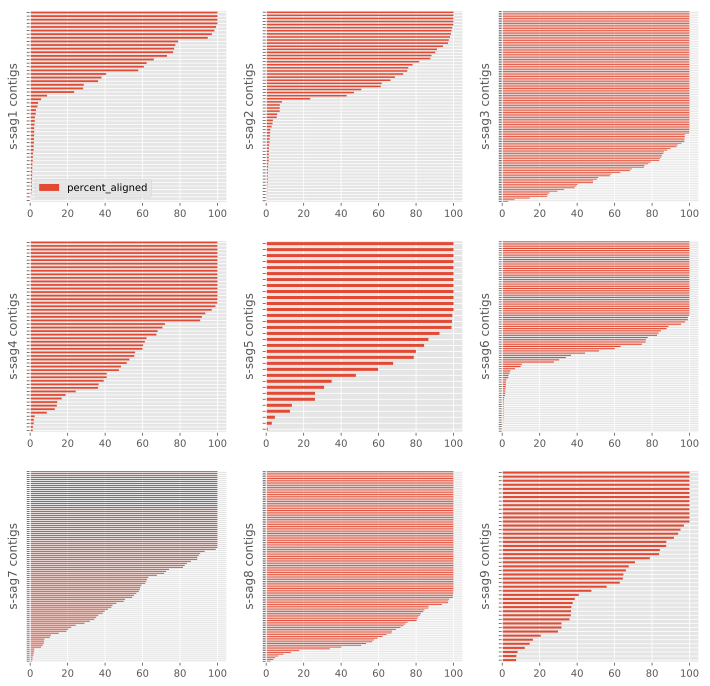

In [60]:
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=False, sharey=False, figsize=(12,12))
all_axes = list(axes[0])+list(axes[1])+list(axes[2])
for i, sagid in enumerate(sorted(s_sags.s_sagID.unique())):
    # Plot align stats for pair
    ax = aligned_df.loc[aligned_df.sagid==sagid].sort_values("percent_aligned").loc[:,["percent_aligned"]].plot(kind="barh",stacked=True, ax=all_axes[i])
    ax.set_yticklabels("")
    ax.set_ylabel("{} contigs".format(sagid))
    if i>0:
        ax.get_legend().remove()
plt.savefig("../../results/figures/SAGs_mummer_overlaps2.png", dpi=300, bbox_inches="tight")

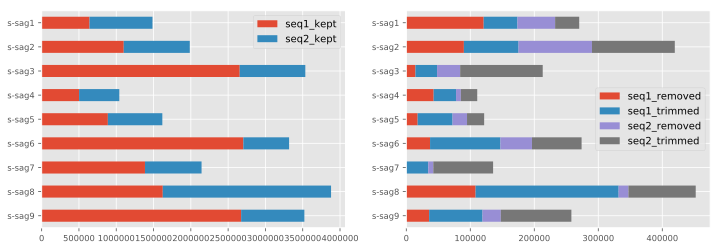

In [61]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
merged_stats_df = pd.DataFrame(merged_stats).T
merged_stats_df = merged_stats_df.loc[sorted(merged_stats_df.index, reverse=True)]
ax1 = merged_stats_df.loc[:,["seq1_kept","seq2_kept"]].plot(kind="barh", stacked=True, ax=axes[0])
ax2 = merged_stats_df.loc[:,["seq1_removed", "seq1_trimmed","seq2_removed", "seq2_trimmed"]].plot(kind="barh", stacked=True, ax=axes[1])
ax1.tick_params(labelsize='small')
ax2.tick_params(labelsize='small')
plt.savefig("../../results/figures/SAGs_mummer_kept_lost2.png", dpi=300, bbox_inches="tight")

Checkm is run on all the s-sags on Rackham using the m_dopson bitbucket repo.

In [22]:
s_sags = pd.read_csv("../../results/checkm-mergers2/s-sags.tsv", header=0, sep="\t", index_col=0)
s_sags.rename(index=lambda x: str(x), inplace=True)

In [66]:
checkm_merged = pd.read_csv("../../results/checkm/s-sag_genomes.2.tab/checkm_results.tab", header=0, index_col=0, sep="\t")
checkm_merged.rename(index=lambda x: str(x).split(".")[0], inplace=True)
# Add actual checkm stats to s_sag dataframe
checkm_merged = pd.merge(s_sags, checkm_merged.loc[:,["Completeness","Contamination","Strain heterogeneity"]], left_on="s_sagID", right_index=True)
checkm_merged = checkm_merged.assign(Current_cont = pd.Series([sag_df.loc[x,"Contamination"] for x in checkm_merged.index], index=checkm_merged.index))
checkm_merged = checkm_merged.assign(Current_strain_het = pd.Series([sag_df.loc[x,"Strain heterogeneity"] for x in checkm_merged.index], index=checkm_merged.index))

In [68]:
checkm_merged.loc[checkm_merged.Contamination<=5]

Cluster  Current_comp  Max_comp s_sagID        Gain  \
2756170308   CLUSTER_1         34.48     55.77  s-sag1   61.745940   
2756170432   CLUSTER_1         25.32     55.77  s-sag1  120.260664   
2756170296   CLUSTER_1         22.32     67.31  s-sag2  201.568100   
2756170347   CLUSTER_1         49.53     67.31  s-sag2   35.897436   
3300021744   CLUSTER_2         30.33     59.62  s-sag4   96.571052   
3300021725   CLUSTER_2         19.87     59.62  s-sag4  200.050327   
3300021814  CLUSTER_10         32.68     63.46  s-sag5   94.186047   
3300021748  CLUSTER_10         23.69     63.46  s-sag5  167.876741   
3300021753   CLUSTER_9         13.79     60.58  s-sag6  339.303843   
3300021788   CLUSTER_9         58.55     60.58  s-sag6    3.467122   

            Completeness  Contamination  Strain heterogeneity  Current_cont  \
2756170308         54.89           2.15                 33.33          0.00   
2756170432         54.89           2.15                 33.33          1.08   
2756170296         70.32           2.69                  0.00          0.00   
2756170347         70.32           2.69                  0.00          0.54   
3300021744         40.15           3.96                100.00          0.00   
3300021725         40.15           3.96                100.00          0.00   
3300021814         52.73           2.73                 66.67          0.91   
3300021748         52.73           2.73                 66.67          0.00   
3300021753         61.51           3.67                 80.00          0.00   
3300021788         61.51           3.67                 80.00          0.44   

            Current_strain_het  
2756170308                 0.0  
2756170432                 0.0  
2756170296                 0.0  
2756170347                 0.0  
3300021744                 0.0  
3300021725                 0.0  
3300021814                 0.0  
3300021748                 0.0  
3300021753                 0.0  
3300021788                 0.0

In [39]:
sag_df.loc[checkm_merged.loc[checkm_merged.Contamination<=5].index]

Cluster                                               name  \
2756170296   CLUSTER_2                     OP3 bacterium JGI_SA12_F09_069   
2756170347   CLUSTER_2                     OP3 bacterium JGI_KA33_D06_042   
2756170432   CLUSTER_2                     OP3 bacterium JGI_SA12_C09_075   
2756170308   CLUSTER_2                     OP3 bacterium JGI_KA33_H05_033   
3300021725   CLUSTER_1  uncultured microorganism JGI SbSrfc.KR11.SmLR....   
3300021744   CLUSTER_1  uncultured microorganism JGI SbSrfc.KR11.SmLR....   
3300021788  CLUSTER_21        uncultured microorganism SbSrfc.KA33.01.G20   
3300021753  CLUSTER_21         uncultured microorganism SbSrfc.KA33.01.F4   
3300021814  CLUSTER_30        uncultured microorganism SbSrfc.KA33.01.E13   
3300021748  CLUSTER_30        uncultured microorganism SbSrfc.KA33.01.F22   

                      Marker lineage  # genomes  # markers  # marker sets  \
2756170296      k__Bacteria (UID203)       5449        102             56   
2756170347     k__Bacteria (UID2565)       2921        152             93   
2756170432     k__Bacteria (UID2565)       2921        152             93   
2756170308      k__Bacteria (UID203)       5449        104             58   
3300021725     k__Bacteria (UID1452)        924        151            101   
3300021744      k__Bacteria (UID203)       5449        100             55   
3300021788  o__Rhizobiales (UID3447)        356        413            248   
3300021753      k__Bacteria (UID203)       5449        104             58   
3300021814     k__Bacteria (UID1452)        924        163            110   
3300021748     k__Bacteria (UID1452)        924        163            110   

            Completeness  Contamination  Strain heterogeneity  \
2756170296         22.32           0.00                   0.0   
2756170347         49.53           0.54                   0.0   
2756170432         25.32           1.08                   0.0   
2756170308         34.48           0.00                   0.0   
3300021725         19.87           0.00                   0.0   
3300021744         30.33           0.00                   0.0   
3300021788         58.55           0.44                   0.0   
3300021753         13.79           0.00                   0.0   
3300021814         32.68           0.91                   0.0   
3300021748         23.69           0.00                   0.0   

            Genome size (bp)  ...  Gene count  Coding density.1  \
2756170296            999953  ...        1008               NaN   
2756170347           1190650  ...        1045               NaN   
2756170432            902796  ...         908               NaN   
2756170308            762790  ...         698               NaN   
3300021725            546733  ...         580               NaN   
3300021744            544574  ...         597               NaN   
3300021788           2741350  ...        2657               NaN   
3300021753            662477  ...         658               NaN   
3300021814            905555  ...         863               NaN   
3300021748            752829  ...         774               NaN   

            Translation table.1  # descendant genomes  Lineage: GC mean  \
2756170296                  NaN                   3.0         40.770762   
2756170347                  NaN                  88.0         44.228229   
2756170432                  NaN                  88.0         44.228229   
2756170308                  NaN                  88.0         44.228229   
3300021725                  NaN                   8.0         51.680174   
3300021744                  NaN                  72.0         38.969742   
3300021788                  NaN                   8.0         61.060434   
3300021753                  NaN                   8.0         61.060434   
3300021814                  NaN                   2.0         56.291185   
3300021748                  NaN                   2.0         56.291185   

            Lineage: GC std  Lineage: g

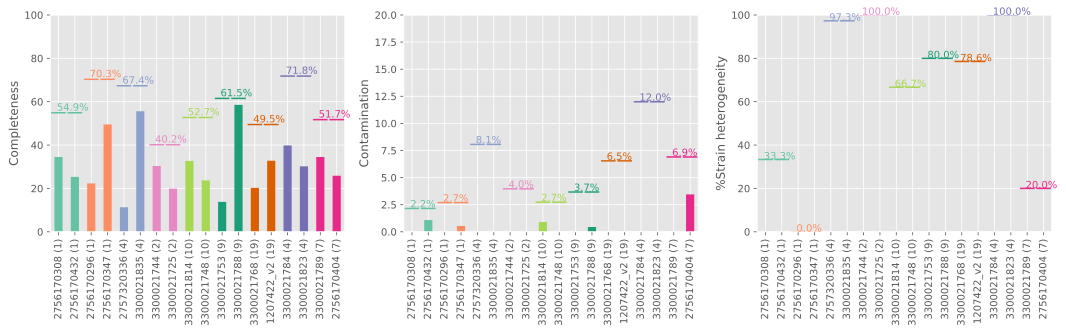

In [70]:
merged_colors1 = make_seaborn_colors(checkm_merged.head(10), column="s_sagID", palette="Set2").to_dict()
merged_colors = make_seaborn_colors(checkm_merged.tail(8), column="s_sagID", palette="Dark2").to_dict()
merged_colors.update(merged_colors1)
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18,4), sharey=False)
ax1 = checkm_merged.Current_comp.plot(kind="bar", color=[merged_colors[x] for x in checkm_merged.index], ax=axes[0])
ax1.set_ylim(0,100)
annotate_bars(ax=ax1, colors=merged_colors, df=checkm_merged, ylabel="", column="Completeness", line_offset=0.05, text_x=0.1)
ax2 = checkm_merged.Current_cont.plot(kind="bar", color=[merged_colors[x] for x in checkm_merged.index], ax=axes[1])
ax2.set_ylim(0,20)
axes[0].set_ylabel("Completeness")
annotate_bars(ax=ax2, colors=merged_colors, df=checkm_merged, ylabel="Contamination", column="Contamination", line_offset=0.05, text_x=0.1, text_y=0.1)
ax3 = checkm_merged.Current_strain_het.plot(kind="bar", color=[merged_colors[x] for x in checkm_merged.index], ax=axes[2])
ax3.set_ylim(0,100)
annotate_bars(ax=ax3, colors=merged_colors, df=checkm_merged, ylabel="%Strain heterogeneity", column="Strain heterogeneity", line_offset=0.05, text_x=0.1, text_y=0.1)
plt.savefig("../../results/figures/SAGs_actual_gain2.png", dpi=300, bbox_inches="tight")

In [75]:
"|".join(s_sags.loc[s_sags.s_sagID.isin(["s-sag1","s-sag2","s-sag4","s-sag5","s-sag6"])].index)

'2756170308|2756170432|2756170296|2756170347|3300021744|3300021725|3300021814|3300021748|3300021753|3300021788'